### Here are the main steps to follow:
- [Importing libraries and loading the data](#Importing-and-loading-data)
- [EDA](#EDA)
- [Data-leakage](#Data-leakage)
- [Feature engineering](#Feature-engineering)
- [Training](#Training)
- [Prediction](#Prediction)

## Importing and loading data

In [1]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import gc

%matplotlib inline

In [2]:
df_train = pd.read_csv('sales_train.csv.gz')
df_test = pd.read_csv('test.csv.gz')

items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')

## EDA

#### check item_cnt_day range

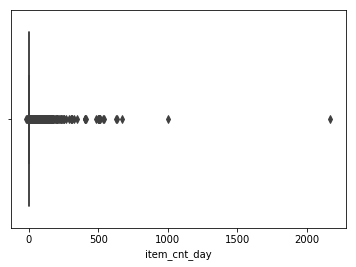

In [3]:
sns.boxplot(x=df_train.item_cnt_day)

##### It looks like transactions with item_cnt_day > 1000 is outliers, so remove them

In [4]:
df_train = df_train[df_train.item_cnt_day<1001]

#### check item_price range

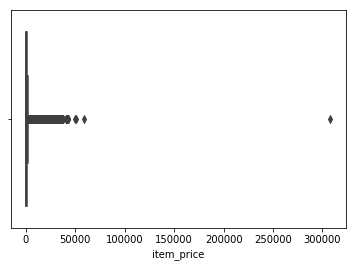

In [5]:
sns.boxplot(x=df_train.item_price)

Again item_price > 100000 seens like outliers, remove them

In [6]:
df_train = df_train[df_train.item_price<100000]

##### check for nan's

In [7]:
df_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

##### check for negative values

In [8]:
df_train[df_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


##### replace it with median of this shop id of this item id within the date_block_num median

In [9]:
df_train.loc[df_train.item_price<0, 'item_price'] = df_train[(df_train.shop_id==32)&(df_train.item_id==2973)&(df_train.date_block_num==4)&(df_train.item_price>0)].item_price.median()

#### some shops are duplicated of each other, correct them

In [21]:
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57

df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58

df_train.loc[df_train.shop_id == 10, 'shop_id'] = 11

#### now let's see some visualization

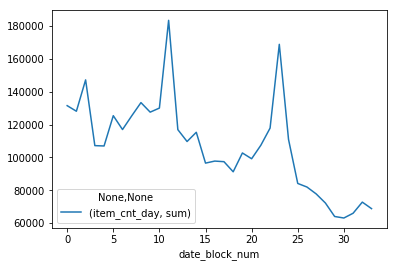

In [10]:
#let's see item_cnt_day in each date_block_num
df_train.groupby(['date_block_num']).agg({'item_cnt_day': ['sum']}).plot()

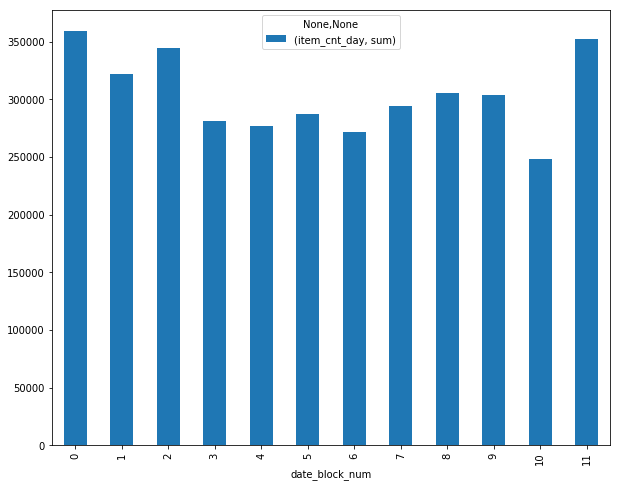

In [19]:
#let's see item_cnt_day vs each month
df_train.groupby(df_train.date_block_num%12).agg({'item_cnt_day': ['sum']}).plot.bar(figsize=(10, 8))

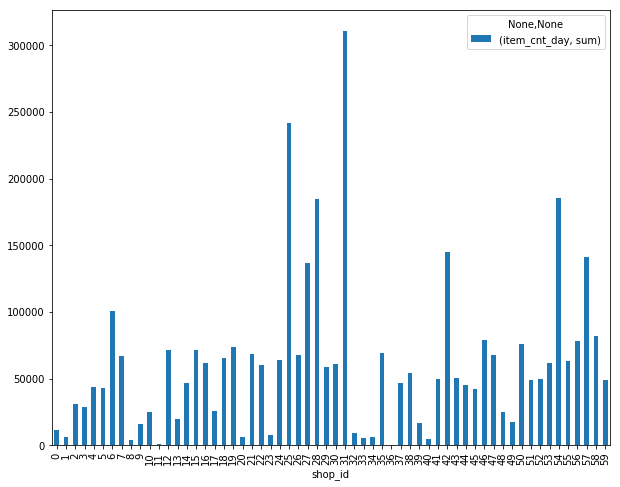

In [20]:
#let's see sales for each shop
df_train.groupby(['shop_id']).agg({'item_cnt_day': ['sum']}).plot.bar(figsize=(10, 8))

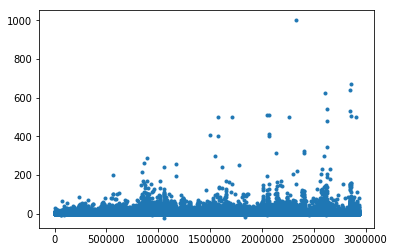

In [18]:
#Is there's a realtion between item_cnt_day and the order of the data
plt.plot(df_train.item_cnt_day,'.')

## Data leakage

#### Since the training and test set are split on a future time for test set, i couldn't utilize any data leakage

## Feature engineering

##### from here the code needs a lot of memory, so i didn't ran them on this notebook, but on kaggle kerenl 

In [ ]:
#create a grid with all possible date_block_num/shop_id/item_id combination
grid = []
for block_num in df_train['date_block_num'].unique():
    cur_shops = df_train[df_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = df_train[df_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)


# group each date_block_num and make our target variable (item_cnt_month)
df_train['item_cnt_day'] = df_train['item_cnt_day'].clip(0,20)
groups = df_train.groupby(['shop_id', 'item_id', 'date_block_num'])
tr = groups.agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()
tr = tr.rename(columns = {'item_cnt_day' : 'item_cnt_month'})
tr['item_cnt_month'] = tr['item_cnt_month'].clip(0,20)

#merge to our main data
index_cols = ['shop_id', 'item_id', 'date_block_num']
tr = pd.merge(grid,tr,how='left',on=index_cols)
tr.item_cnt_month = tr.item_cnt_month.fillna(0)
tr.item_price = tr.item_price.fillna(0)

#clean memory
del grid, df_train
gc.collect()

#### Modify the test/shops/items/cats data

In [ ]:
#fix name of shops in test as we did in train
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

#we don't need the ID column
df_test = df_test.drop(['ID'], axis=1)

#make new column of date_block_num so we can concat it with the train data
df_test['date_block_num'] = 34
df_test['item_cnt_month'] = 0

#concat train and test data
df = pd.concat([tr, df_test], axis = 0, sort=False)

#clean memory
del df_test
gc.collect()

In [ ]:
#fix shop name
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

#get city_code of shop from shop name
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

#what's important is only shop_id and city_code
shops = shops[['shop_id','city_code']]

In [ ]:
#get type_code/subtype_code of item from cats data
cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [ ]:
#merege shops, itms and cats with our main data
df = pd.merge(df, shops, on=['shop_id'], how='left')
df = pd.merge(df, items, on=['item_id'], how='left')
df = pd.merge(df, cats, on=['item_category_id'], how='left')

#downcast 
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['date_block_num'] = df['date_block_num'].astype(np.int8)

#clean memory
del shops, items, cats
gc.collect()

In [ ]:
#add new column that repesent the month
df['month'] = df['date_block_num']%12
df['month'] = df['month'].astype(np.int8)

#let's keep an array of the new features we'll use
new_features = ['month']

#### add mean encoding features

In [ ]:
#find mean of all item_cnt_month to fill nan with
global_mean =  df['item_cnt_month'].mean()

#categories we will get mean encoding for
mean_encoded_cols = ['shop_id', 'item_id', 'item_category_id']
#list of new features
mean_encoded_fes = []

for col in mean_encoded_cols:
    #Expanding mean scheme
    col_tr = df[[col] + ['item_cnt_month']]
    
    #new feature name
    fe_name = col + '_cnt_month_mean_Expanding'
    mean_encoded_fes.append(fe_name)
    
    #cumulative sum of previous n-1 rows
    cumsum = col_tr.groupby(col)['item_cnt_month'].cumsum() - col_tr['item_cnt_month']
    
    #cumlative cnt of current elments in current group
    sumcnt = col_tr.groupby(col).cumcount()
    
    #take ratio
    col_tr[fe_name] = cumsum / sumcnt
    
    col_tr[fe_name].fillna(global_mean, inplace=True)
    
    #merge to main data
    df = pd.concat([df, col_tr[fe_name]], axis = 1)

#### Since this a time series problem, we can't use target features in training, but we use lags of them

In [ ]:
def lag_feature(_df, lags, col, add_to_new = 1):
    #get lag feature of col
    tmp = _df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        feature_name = col+'_lag_'+str(i)
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', feature_name]
        shifted['date_block_num'] += i
        _df = pd.merge(_df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        if add_to_new:
            new_features.append(feature_name)
    return _df

In [ ]:
#add lag of mean encoded features
for col in mean_encoded_fes:
    #use lags of 1,3
    df = lag_feature(df, [1,3], col)
    #drop this col after creating lag from it
    df.drop([col], axis=1, inplace=True)

In [ ]:
#create lag from the target
df = lag_feature(df, [1,2,3,6], 'item_cnt_month')

#### let's group by some categorial features and add lag of this grouping

In [ ]:
group = df.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num'], how='left')
df['date_avg_item_cnt'] = df['date_avg_item_cnt'].astype(np.float16)
df = lag_feature(df, [1], 'date_avg_item_cnt')
df.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = df.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','item_id'], how='left')
df['date_item_avg_item_cnt'] = df['date_item_avg_item_cnt'].astype(np.float16)
df = lag_feature(df, [1,2, 3], 'date_item_avg_item_cnt')
df.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = df.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
df['date_shop_cat_avg_item_cnt'] = df['date_shop_cat_avg_item_cnt'].astype(np.float16)
df = lag_feature(df, [1], 'date_shop_cat_avg_item_cnt')
df.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = df.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','item_category_id'], how='left')
df['date_cat_avg_item_cnt'] = df['date_cat_avg_item_cnt'].astype(np.float16)
df = lag_feature(df, [1], 'date_cat_avg_item_cnt')
df.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
group = df.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num','shop_id'], how='left')
df['date_shop_avg_item_cnt'] = df['date_shop_avg_item_cnt'].astype(np.float16)
df = lag_feature(df, [1, 2, 3, 6], 'date_shop_avg_item_cnt')
df.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#date_item_city_avg_item_cnt
group = df.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
df['date_item_city_avg_item_cnt'] = df['date_item_city_avg_item_cnt'].astype(np.float16)
df = lag_feature(df, [1, 3], 'date_item_city_avg_item_cnt')
df.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
#create a feature of first item_shop_first_sale
df['item_shop_first_sale'] = df['date_block_num'] - df.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
new_features.append('item_shop_first_sale')

In [ ]:
#create a feature item_first_sale
df['item_first_sale'] = df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')
new_features.append('item_first_sale')

In [ ]:
#create a feaure of number of days
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
df['days'] = df['month'].map(days).astype(np.int8)
new_features.append('days')

## Training

#### Training was done on kaggle kerenl so this cells are just copy of the kerenl without running them localy

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

#lgbm
#best parameters found after some testing
lgb_params = {
               'feature_fraction': 0.3,
               'metric': 'rmse',
               'nthread':3, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.6, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**5,
               'bagging_freq':1,
               'verbose':0,
               'lambda_l2':0.5
              }

validation = 1

#### some preparation for training

In [ ]:
#If there's na fill it with zero
df = df.fillna(0)
#features we will use in training
fes = new_features + ['date_block_num','item_id','shop_id', 'item_category_id',
                      'subtype_code']
#our target feature
y_f = ['item_cnt_month']
#drop first 11 months, because we used lag of 12
df = df[df.date_block_num > 11]

#### split for validation or test

In [ ]:
#if we will validate, then don't use data from test-set, where date_block_num == 35
if validation:
    f_tr = df[df.date_block_num < 34]
    y_tr = f_tr[y_f]
    f_tr = f_tr[fes]
    
    lv2 = [27, 28, 29, 30, 31, 32, 33]
else:
    f_tr = df[df.date_block_num < 35]
    y_tr = f_tr[y_f]
    f_tr = f_tr[fes]
    
    lv2 = [27, 28, 29, 30, 31, 32, 33, 34]

In [ ]:
#get our truth prediction 
y_tr2 = y_tr[f_tr.date_block_num.isin(lv2)]

#Our training data for level 2 model, will be prediction from level 1 models
f_tr2 = np.zeros([y_tr2.shape[0], 3])

#counter to fill f_tr2
ss = 0

# Now fill `X_train_level2` with metafeatures
for cur_block_num in lv2:
    
    print(cur_block_num)
    
    x_t = f_tr[f_tr.date_block_num < cur_block_num]
    y_t = y_tr[f_tr.date_block_num < cur_block_num]
    
    x_te = f_tr[f_tr.date_block_num == cur_block_num]
    y_te = y_tr[f_tr.date_block_num == cur_block_num]
    
    #train models
    
    #rf
    #print('training rf')
    m = RandomForestRegressor(n_estimators=10, min_samples_leaf=7, max_features='log2', n_jobs=-1)
    m.fit(x_t.values, y_t.values.ravel())
    
    
    #lgb
    #print('training lgb')
    lg = lgb.train(lgb_params, lgb.Dataset(x_t.values, label=y_t.values.ravel()), 200)
    
    
    #sgd
    #print('training sgd')
    sg = SGDRegressor(alpha=0.1)
    sg.fit(x_t.values, y_t.values.ravel())
    
    se = ss + x_te.shape[0]
    f_tr2[ss:se, 0] = m.predict(x_te.values)
    f_tr2[ss:se, 1] = lg.predict(x_te.values)
    f_tr2[ss:se, 2] = sg.predict(x_te.values)
    
    ss = se

In [ ]:
#Last block will be our testing block, whether we're validating or testing
test_nrow = x_te.shape[0]

#split data for testing
f_t2 = f_tr2[ : -test_nrow, :]

f_te2 = f_tr2[ -test_nrow: , :]

y_t2 = y_tr2[ : -test_nrow]

y_te2 = y_tr2[ -test_nrow : ]

In [ ]:
#Train second level model on the predictions of first models
#tried some different models and different regulazation and this was best one
reg = Ridge(alpha=3.0)
reg.fit(f_t2, y_t2.values.ravel())

## Prediction

In [ ]:
if validation:
    #for validation print r-square score
    print('R-squared for training data is: %f' % r2_score(y_t2.values.ravel(), reg.predict(f_t2)))
    print('R-squared for testing data is: %f' % r2_score(y_te2.values.ravel(), reg.predict(f_te2)))
else:
    #predict and build file for submission
    pred = reg.predict(f_te2)

    pred = pred.clip(0,20)

    df = pd.DataFrame(pred, columns = ['item_cnt_month'])
    df['ID'] = df.index
    df = df.set_index('ID')

    df.to_csv('test_preds.csv')